In [2]:
import numpy as np # linear algebra
import pandas as pd 

import os
from skimage.io import imsave, imread

import matplotlib.pyplot as plt
import seaborn as sns

xtrain_data_path = '../data/x_train/images'
ytrain_data_path = '../data/y_train/images'

In [3]:
import glob
patients = {}
for filename in glob.glob(os.path.join(xtrain_data_path, "*.tif")):
    mask_name = os.path.basename(filename).strip('.tif') + "_mask.tif"
    mask_name = os.path.join(ytrain_data_path, mask_name)        
        
    patientID = os.path.basename(filename).strip('.tif').split('_')[0]
    
    if patientID not in patients:
        patients[patientID] = [(filename, mask_name)]
    else:
        patients[patientID] += [(filename, mask_name)]

In [4]:
patient_x = {k: np.array([ imread(i[0], as_gray=True, plugin='pil') 
                          for i in v]) for k, v in patients.items()}
patient_y = {k: np.array([ imread(i[1], as_gray=True, plugin='pil') for i in v]) 
                for k, v in patients.items()}

## Distribution of BP regions

In [9]:
roi = []
others = []

#plt.imshow(patient_x['1'][0])
for i in range(1, len(patient_x.keys())+1):
    i = str(i)
    for x, y in zip(patient_x[i], patient_y[i]):
        if y.sum() == 0: continue
        bp = x.copy()
        
        # Extract BP region
        i, j = np.where(y)
        indices = np.meshgrid(np.arange(min(i), max(i) + 1), 
                              np.arange(min(j), max(j) + 1), indexing='ij')
        bp = bp[indices] / 255.0
        roi += [bp]
        
        # Extract other region
        other = x.copy()
        flat_indices = np.ravel_multi_index(indices, dims=other.shape)
        other = other.flatten()[~flat_indices] / 255.0
        
        others += [other]

In [5]:
rois = []
for r in roi:
    for v in r.flatten():
        rois += [v]

In [6]:
others_flat = []
for o in others:
    for v in o.flatten():
        others_flat += [v]

In [7]:
len(rois), len(others_flat)

(26982182, 26982182)

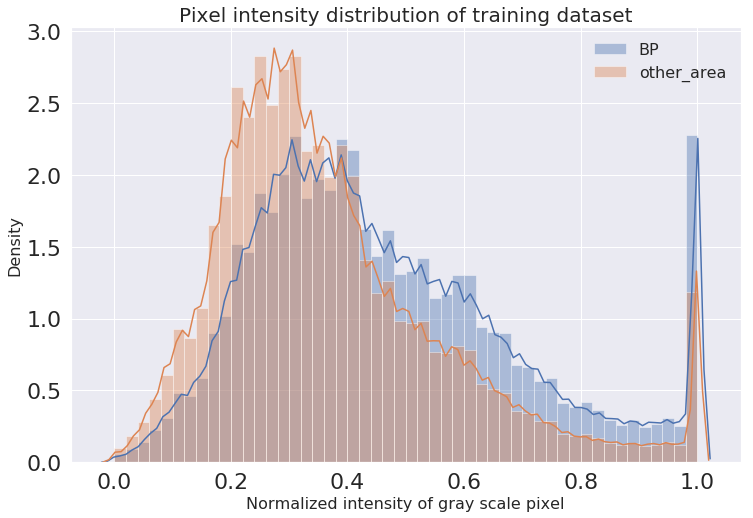

In [98]:
plt.style.use('seaborn-dark')
sns.set(font_scale = 2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.distplot(rois, label='BP')
sns.distplot(others_flat, label='other_area')

ax.set_xlabel('Normalized intensity of gray scale pixel', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Pixel intensity distribution of training dataset", fontsize=20)
ax.legend(fontsize=16)
plt.style.use('seaborn-white')
plt.savefig('pixel_intensity_training.png', dpi=300)
plt.show()
plt.close()

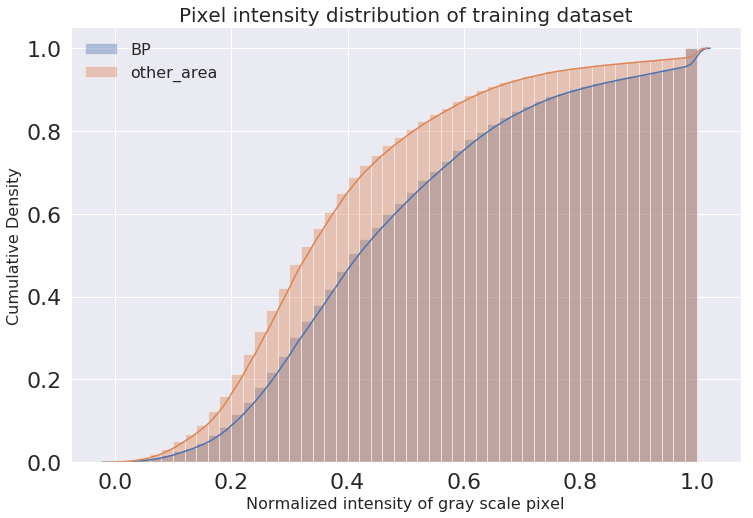

In [8]:
plt.style.use('seaborn-dark')
sns.set(font_scale = 2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.distplot(rois, label='BP',
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
sns.distplot(others_flat, label='other_area',
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

ax.set_xlabel('Normalized intensity of gray scale pixel', fontsize=16)
ax.set_ylabel('Cumulative Density', fontsize=16)
ax.set_title("Pixel intensity distribution of training dataset", fontsize=20)
ax.legend(fontsize=16)
plt.style.use('seaborn-white')
plt.savefig('pixel_intensity_training_cdf.png', dpi=300)
plt.show()
plt.close()

In [99]:
from scipy.stats import ks_2samp
ks, pval = ks_2samp(rois, others_flat)

---
### ROI sizes

In [27]:
p_roi = []
for i in range(1, len(patient_x.keys())+1):
    i = str(i)
    roi = []
    for x, y in zip(patient_x[i], patient_y[i]):
        if y.sum() == 0: continue
        bp = x.copy()
        
        # Extract BP region
        i, j = np.where(y)
        indices = np.meshgrid(np.arange(min(i), max(i) + 1), 
                              np.arange(min(j), max(j) + 1), indexing='ij')
        bp = bp[indices] / 255.0
        roi += [bp]
        
    p_roi += [ roi ]

In [40]:
alldata = []
for i in range(len(p_roi)):
    roi = p_roi[i]
    region_width = []
    region_height = []
    for r in roi:
        height, width = r.shape
        region_width += [ width ]
        region_height += [ height ]
        
    data = pd.DataFrame()
    data['w'] = region_width
    data['h'] = region_height
    data['id'] = [ i for x in range(len(region_width)) ]
    alldata += [data]
    
alldata = pd.concat(alldata, axis=0)

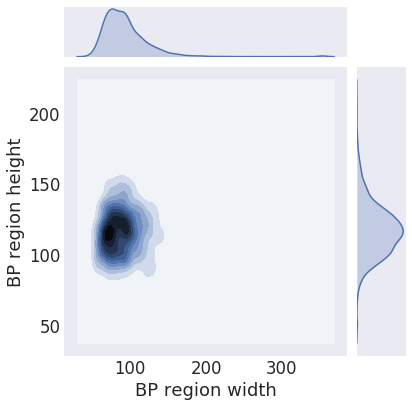

In [46]:
sns.set(font_scale = 1.5)
plt.style.use('seaborn-dark')

jp = sns.jointplot(x='w', y='h', data=alldata, kind='kde')
#jp.ax_joint.scatter(x='w', y='h', data=alldata, c='id')
jp.ax_joint.set_xlabel('BP region width')
jp.ax_joint.set_ylabel('BP region height')
plt.show()
plt.close()